In [9]:
from phidl import Device, Layer, LayerSet, Port
from phidl.device_layout import DeviceReference
from phidl import quickplot as qp

import phidl.geometry as pg
import phidl.utilities as pu
import phidl.routing as pr
import phidl.path as pp

import numpy as np
import pickle

from dataclasses import dataclass, field, replace

from typing import Tuple, Optional, Union

import itertools
import importlib

from components import utils
importlib.reload(utils)

from components import default_layerset
importlib.reload(default_layerset)
from components import frame
importlib.reload(frame)
from components import feedline
importlib.reload(feedline)
from components import spiral
importlib.reload(spiral)
from components import junction
importlib.reload(junction)
from components import resistor
importlib.reload(resistor)
from components import junction_resistor
importlib.reload(junction_resistor)
from components import ground_capacitor
importlib.reload(ground_capacitor)
from components import squid_resistor
importlib.reload(squid_resistor)
from components import junction_squid_resistor
importlib.reload(junction_squid_resistor)

from components.default_layerset import default_ls
from components.frame import Frame, FrameParams
from components.feedline import Feedline, FeedlineParams, SquarePortParams
from components.spiral import Spiral, SpiralParams
from components.junction import JJ, JJParams
from components.resistor import Resistor, ResParams
from components.junction_resistor import JJResistor, CapaParams
from components.ground_capacitor import GroundCapa, GroundCapaParams
from components.squid_resistor import SquidResistor, SquidParams, Squid
from components.junction_squid_resistor import JJSquidResistor
from components.utils import WritefieldParams

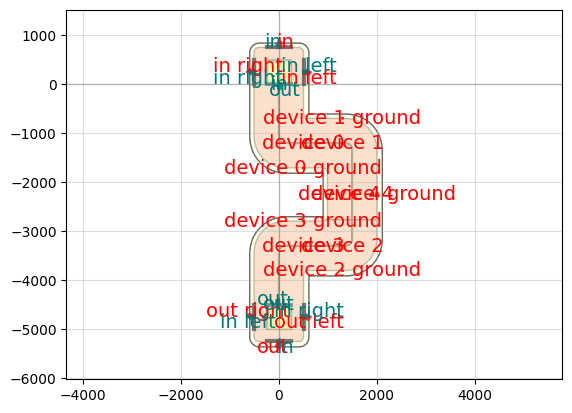

In [10]:
feedline_left = Feedline()

feedline_points = [(0, 0), (1200, 0), (1200, 1500), (3300, 1500), (3300, 0), (4500, 0)]
# device_points = [(1200, 600), (1200, 1000), (1200, 1400), (3300, 1400), (3300, 1000), (3300, 600)]
# ground_points = [(700, 600), (700, 1000), (700, 1400), (3800, 1400), (3800, 1000), (3800, 600)]

device_points = [(1200, 500), (1200, 1300), (3300, 1300), (3300, 500), (2250, 1500)]
device_orientations = [0, 180, 0, 180, 90]
ground_points = [(1705, 500), (695, 1300), (3805, 1300), (2795, 500), (2250, 2005)]

feedline_left.generate_feedline(FeedlineParams(feedline_points=feedline_points, 
                                               device_points=device_points, 
                                               device_ground_points=ground_points,
                                               device_orientations=device_orientations))

feedline_left.device.rotate(-90)


qp(feedline_left.device)

In [11]:
# make spirals
# Ns = np.linspace(16.5, 16.8, 4)
Ns = np.linspace(15.4, 15.7, 4)
print(Ns)

spirals: list[Spiral] = []

for N in Ns:
    spiral = Spiral()
    spiral.generate_spiral(SpiralParams(N=N))

    spirals.append(spiral)

spiral = Spiral()
spiral.generate_spiral(SpiralParams(N=15.3))
spirals.append(spiral)

print([np.round(spiral.get_resonance_frequency()) for spiral in spirals])

[15.4 15.5 15.6 15.7]
[9978920550.0, 9857103740.0, 9737503993.0, 9620067833.0, 10103009562.0]


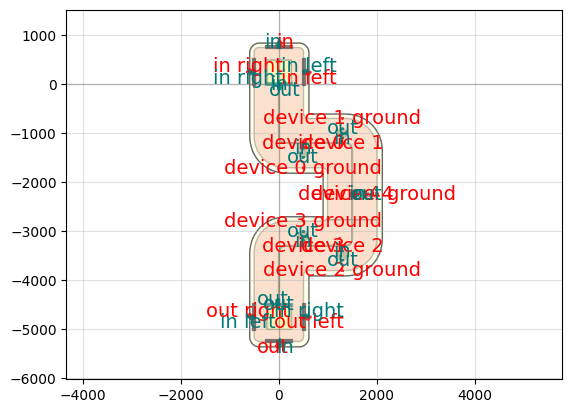

In [12]:
coupling_distance = 100
Resonators: list[DeviceReference] = []

for i,spiral in enumerate(spirals):
    Resonators.append(feedline_left.device << spiral.device)

    Resonators[-1].connect('in', feedline_left.device.ports[f'device {i}'])

    #angle = device_orientations[i]*((2*np.pi)/360)
    #Resonators[-1].move((coupling_distance * np.cos(angle), coupling_distance * np.sin(angle)))
    normal = Resonators[-1].ports['out'].normal[1] - Resonators[-1].ports['out'].normal[0]
    Resonators[-1].move(normal * coupling_distance)

#feedline_bot.correct_optical_layer()

qp(feedline_left.device)

In [13]:
capa_spacing = 1
shadow_shift = 0.3

def connect_to_resonator(element: Union[JJResistor, SquidResistor, JJSquidResistor], 
                         resonator: DeviceReference,
                         device_number: int, 
                         capa_distance: float = capa_spacing + shadow_shift) -> None:
    
    resonator_normal = resonator.ports['out'].normal[1] - resonator.ports['out'].normal[0]
    element_normal = element.bot_connector.ports['capa out'].normal[1] - element.bot_connector.ports['capa out'].normal[0]

    angle = np.round((360/(2*np.pi)) * np.arccos(np.clip(np.dot(resonator_normal,-element_normal), -1, 1)))%360

    if angle != 0:
        element.device.rotate(-angle)
        element.device.mirror()

    element.device.move(element.bot_connector.ports['capa out'], resonator.ports['out'])
    element.device.move(capa_distance * resonator_normal)


def add_ground_capacitor(element: Union[JJResistor, SquidResistor, JJSquidResistor], 
                         feedline: Feedline,
                         device_number: int, 
                         capa_distance: float = capa_spacing + shadow_shift) -> None:

    distance_to_ground = np.abs(- element.top_connector.ports['capa out'].y + feedline.device.ports[f'device {device_number} ground'].y) + capa_distance

    ground_capa = GroundCapa()
    ground_capa.generate_ground_capa(GroundCapaParams(distance_to_ground=distance_to_ground))

    ground_normal = feedline.device.ports[f'device {device_number} ground'].normal[1] - feedline.device.ports[f'device {device_number} ground'].normal[0]
    capa_normal = ground_capa.pad.ports['ground'].normal[1] - ground_capa.pad.ports['ground'].normal[0]
    
    angle = np.round((360/(2*np.pi)) * np.arccos(np.clip(np.dot(ground_normal,capa_normal), -1, 1)))%360

    if angle != 0:
        ground_capa.device.rotate(angle)

    ground_capa.device.move(ground_capa.plate.ports['capa'], element.top_connector.ports['capa out'])
    ground_capa.device.move(-capa_distance * ground_normal)

    feedline.device << ground_capa.device

In [14]:
def connect_to_resonator(element: Union[JJResistor, SquidResistor, JJSquidResistor, Squid, JJ],
                         element_port_name: str,
                         resonator: DeviceReference, 
                         capa_distance: float = capa_spacing + shadow_shift) -> None:

    element_port = element.device.ports[element_port_name]

    resonator_normal = resonator.ports['out'].normal[1] - resonator.ports['out'].normal[0]
    element_normal = element_port.normal[1] - element_port.normal[0]

    angle = np.round((360/(2*np.pi)) * np.arccos(np.clip(np.dot(resonator_normal,-element_normal), -1, 1)))%360

    if angle != 0:
        element.device.rotate(-angle)
        element.device.mirror()

    element.device.move(element_port, resonator.ports['out'])
    element.device.move(capa_distance * resonator_normal)

def add_ground_capacitor(element: Union[JJResistor, SquidResistor, JJSquidResistor],
                         element_port_name: str, 
                         feedline: Feedline,
                         device_number: int, 
                         capa_distance: float = capa_spacing + shadow_shift) -> None:

    element_port: Port = element.device.ports[element_port_name]

    distance_to_ground = np.abs(- element_port.y + feedline.device.ports[f'device {device_number} ground'].y) + capa_distance

    ground_capa = GroundCapa()
    ground_capa.generate_ground_capa(GroundCapaParams(distance_to_ground=distance_to_ground))

    ground_normal = feedline.device.ports[f'device {device_number} ground'].normal[1] - feedline.device.ports[f'device {device_number} ground'].normal[0]
    capa_normal = ground_capa.pad.ports['ground'].normal[1] - ground_capa.pad.ports['ground'].normal[0]
    
    angle = np.round((360/(2*np.pi)) * np.arccos(np.clip(np.dot(ground_normal, capa_normal), -1, 1)))%360

    if angle != 0:
        ground_capa.device.rotate(angle)

    ground_capa.device.move(ground_capa.plate.ports['capa'], element_port)
    ground_capa.device.move(-capa_distance * ground_normal)

    feedline.device << ground_capa.device

In [15]:

QuantumCircuits: list[DeviceReference] = []

writefield_params = WritefieldParams()

# 4 junctions with Squid and resistor
jj_params = JJParams()
squid_params = SquidParams(loop_height=15, total_length=25)
capa_params = CapaParams()

list_res_params = []
list_res_params.append(ResParams(small_resistor=True, connectors=False, num_segments=5, segment_length=25)) #10kOhm
list_res_params.append(ResParams(num_segments=2, segment_length=25)) #100kOhm
list_res_params.append(ResParams(num_segments=2, segment_length=50)) #200kOhm
list_res_params.append(ResParams(num_segments=4, segment_length=50)) #400kOhm


for i,res_param in enumerate(list_res_params):
    jj_squid_resistor = JJSquidResistor()
    jj_squid_resistor.generate_junction_squid_resistor(jj_params, squid_params, res_param, capa_params, writefield_params)

    

    #connect_to_resonator(jj_squid_resistor, Resonators[i], i)
    connect_to_resonator(jj_squid_resistor, 'capa bot', Resonators[i])

    QuantumCircuits.append(feedline_left.device << jj_squid_resistor.device)

    #add_ground_capacitor(jj_squid_resistor, feedline_left, device_number=i)
    add_ground_capacitor(jj_squid_resistor, 'capa top', feedline_left, device_number=i)

feedline_left.device.write_gds('Sonnet_Feedline_Left.gds')

feedline_left.correct_optical_layer()

In [16]:
feedline_left.device.write_gds('Feedline_Left.gds')

with open('feedline_left.pkl', 'wb') as f:
    pickle.dump(feedline_left, f)